In [1]:
from StackGP import *
import sympy as sym
import pandas as pd
import numpy as np

In [3]:
pip install --upgrade numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.3 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
Note: you may need to restart the kernel to use updated packages.


In [4]:
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/195_auto_price/195_auto_price.csv')

In [10]:
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

In [2]:
# Compute Hess
def ComputeSymbolicHess(model,vars):
    printedModel=sym.simplify(printGPModel(model))
    if type(printedModel)==float:
        return sym.matrices.dense.MutableDenseMatrix(np.zeros((vars,vars)))
    hess=sym.hessian(printedModel, [symbols('x'+str(i)) for i in range(vars)])
    return hess

def EvaluateHess(hess,vars,values):
    numHess=hess.subs({symbols('x'+str(j)):values[j] for j in range(vars)})
    hessN = np.array(numHess).astype(float)
    rankN=np.linalg.matrix_rank(hessN,tol=0.0001*0.0001*10)
    return rankN

def Approx2Deriv(model,values,diff1,diff2,positions): #maybe diff should be relative to the variation of each feature
    term1=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term1=[term1[i]+diff2 if i == positions[1] else term1[i] for i in range(len(term1))]
    term2=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term2=[term2[i]+diff2 if i == positions[1] else term2[i] for i in range(len(term2))]
    term3=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term3=[term3[i]-diff2 if i == positions[1] else term3[i] for i in range(len(term3))]
    term4=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term4=[term4[i]-diff2 if i == positions[1] else term4[i] for i in range(len(term4))]
    return ((evaluateGPModel(model,term1)-evaluateGPModel(model,term2))/((2*diff1))
            -(evaluateGPModel(model,term3)-evaluateGPModel(model,term4))/((2*diff1)))/(2*diff2)

def ApproxHessRank(model,vars,values,diff1=0.001,diff2=0.001):
    hess=[[Approx2Deriv(model,values,diff1,diff2,[i,j]) for i in range(vars)] for j in range(vars)]
    hessN = np.array(hess).astype(float)
    rankN=np.linalg.matrix_rank(hessN,tol=0.0001*0.0001*10)
    return rankN

def ApproxHess(model,vars,values,diff1=0.001,diff2=0.001):
    try:
        hess=[[Approx2Deriv(model,values,diff1,diff2,[i,j]) for i in range(vars)] for j in range(vars)]
    except:
        return np.zeros((vars,vars)).astype(float)
    hessN = np.array(hess).astype(float)
    return hessN

#def HessRank(model,vars,values):
#    try: 
#        with time_limit(.01):
#            hess=ComputeSymbolicHess(model,vars)
#            hess = EvaluateHess(hess,vars,values)
#            #print(hess)
#            return hess
#    except TimeoutException as e:
#        hess=ApproxHessRank(model,vars,values)
        #print(hess)
#        return hess

def HessRank(model,vars,values):
    hess=ApproxHessRank(model,vars,values)
    return hess





# Counts basis terms in a model
def count_basis_terms(equation, expand=False):
    try:
        with time_limit(2):


            if expand:
                # Simplify the equation to standardize the expression
                simplified_eq = simplify(equation)
                # Expand the expression to identify additive terms clearly
                expanded_eq = expand(simplified_eq)
            
                # Separate the terms of the expression
                terms = expanded_eq.as_ordered_terms()
            else:
                terms = equation.as_ordered_terms()
            #print(terms)
            
    except TimeoutException as e:
        return 1000
    return len(terms)

# Determines the number of basis functions in a model by counting +s and -s
def basisFunctionComplexity(model,vars, values,*args):
    try: # values should be max, min, and median with respect to response variable
        return HessRank(model,vars,values)#count_basis_terms(printGPModel(model))
    except:
        return 1000
    
def helperRank(model,vars,low,mid,high):
    try:
        return np.linalg.matrix_rank(ApproxHess(model,vars,low)+ApproxHess(model,vars,mid)+ApproxHess(model,vars,high),tol=0.0001*0.0001*10)
    except:
        return 1000

# Creates a lambda function to be used as a complexity metric when given a target dimensionality and deviation
def basisFunctionComplexityDiff(target, deviation, vars, low, mid, high):
    return lambda model,*args: max(abs(helperRank(model,vars,low,mid,high)-target),(deviation))-deviation


In [31]:
targetID=6.5
IDrange=1    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
#ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
#temp=[mods for mods in ID3Omodels if mods[2][2]<1]
#if len(temp)>0:
#    ID3Omodels=temp
#print("ID3O models done", ID3Omodels[0][2])
#IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
#temp=[mods for mods in IDmodels if mods[2][1]<1]
#if len(temp)>0:
#    IDmodels=temp
#print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300)
print("Tourney models done")

Complexity models done
Tourney models done


In [32]:
#IDComplexities=[stackGPModelComplexity(mod) for mod in IDmodels]
#ID3Complexities=[stackGPModelComplexity(mod) for mod in ID3Omodels]
compComplexities=[stackGPModelComplexity(mod) for mod in compModels]
tourneyComplexities=[stackGPModelComplexity(mod) for mod in tourneyModels]

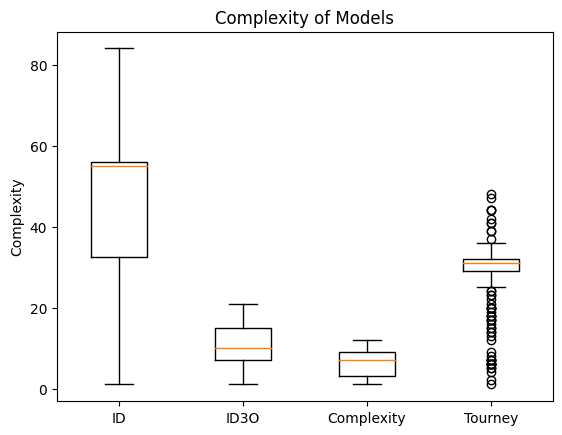

In [9]:
#Box-whisker plot of complexities
import matplotlib.pyplot as plt
plt.boxplot([IDComplexities,ID3Complexities,compComplexities,tourneyComplexities])
plt.xticks([1,2,3,4],['ID','ID3O','Complexity','Tourney'])
plt.ylabel('Complexity')
plt.title('Complexity of Models')
plt.show()

In [14]:
IDFitnesses=[fitness(mod,testInput,testResponse) for mod in IDmodels]
ID3Fitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Omodels]
compFitnesses=[fitness(mod,testInput,testResponse) for mod in compModels]
tourneyFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyModels]
ID3Fitnesses=[fit for fit in ID3Fitnesses if not np.isnan(fit)]

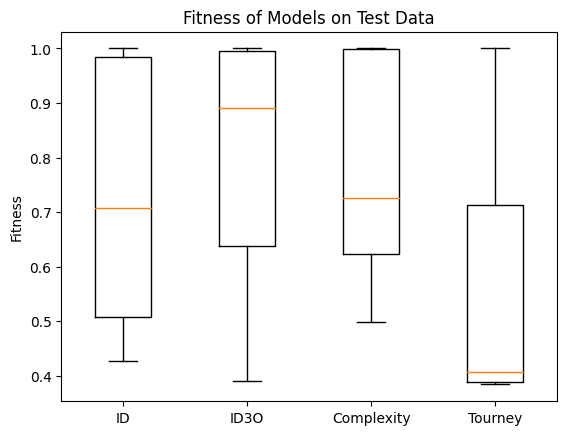

In [15]:
#Box-whisker plot of fitnesses
import matplotlib.pyplot as plt
plt.boxplot([IDFitnesses,ID3Fitnesses,compFitnesses,tourneyFitnesses])
plt.xticks([1,2,3,4],['ID','ID3O','Complexity','Tourney'])
plt.ylabel('Fitness')
plt.title('Fitness of Models on Test Data')
plt.show()

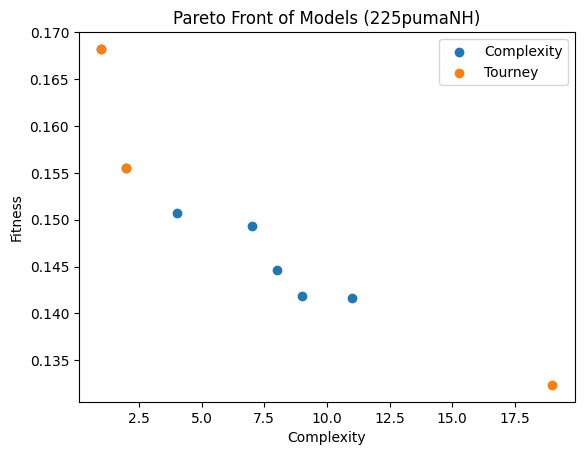

In [33]:
#Pareto front plot of fitnesses vs complexity for each approach
#[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
#[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

#IDFront=paretoTournament(IDmodels)
#ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

#IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
#IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
#ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
#ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

#plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
#plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (225pumaNH)')
plt.legend()

plt.show()

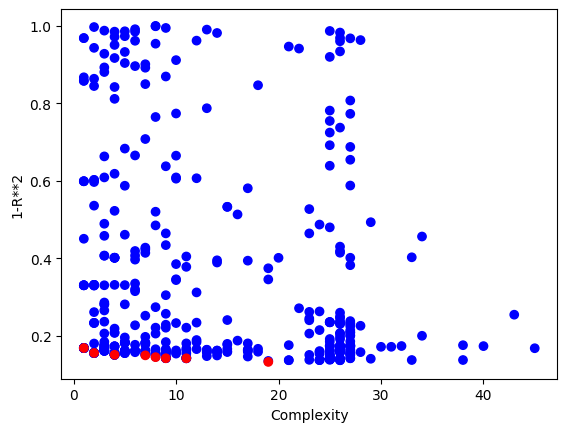

In [34]:
allModels=compModels+tourneyModels
plotModels(allModels)

In [35]:
values=[mod[-1]+[func(mod)] for mod in allModels]

In [35]:
ID3OmodelsVals=[func(mod) for mod in ID3Omodels]

1.5

## 195 Auto Price

In [6]:
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/195_auto_price/195_auto_price.csv')

In [7]:
targetID=2.18
IDrange=.927    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300)
print("Tourney models done")

ID3O models done [0.11643442178503838, 23, 0.8929999999999998]
ID models done [0.12968326677173714, 0.8929999999999998]
Complexity models done
Tourney models done


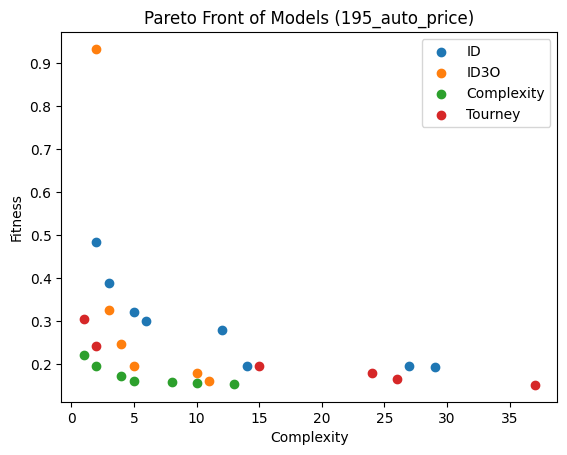

In [8]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (195_auto_price)')
plt.legend()

plt.show()

In [9]:
import dill
dill.dump([IDmodels,ID3Omodels,compModels,tourneyModels],open('Models/195_auto_price(AvgHess).p','wb'))

ZeroDivisionError: 0.0 cannot be raised to a negative power

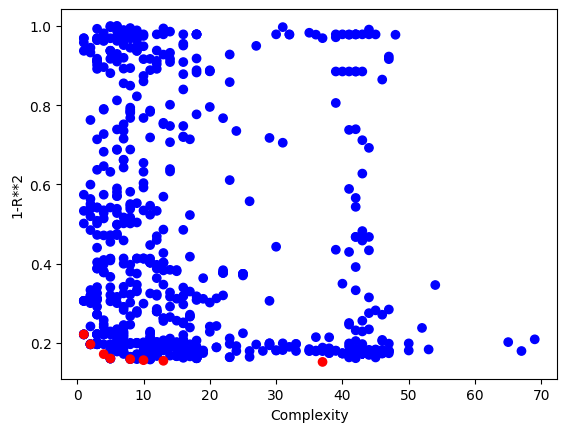

In [10]:
allModels=IDmodels+ID3Omodels+compModels+tourneyModels
plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

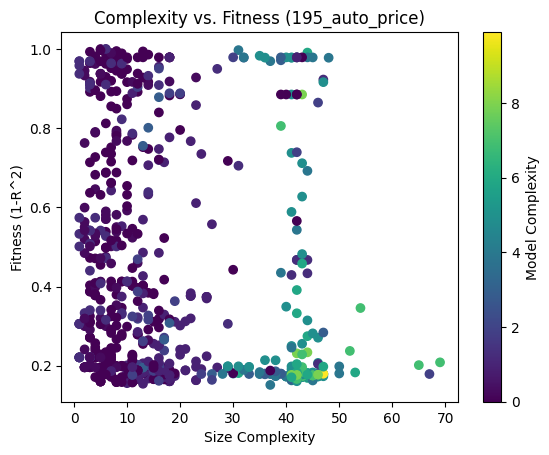

In [11]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (195_auto_price)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

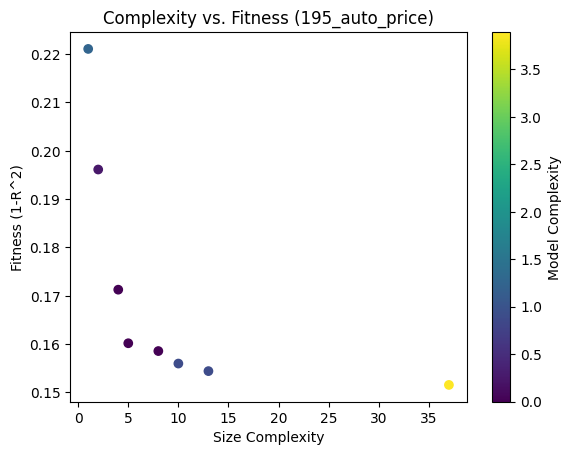

In [12]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (195_auto_price)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 641 fri c1 500 10

In [13]:
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/641_fri_c1_500_10/641_fri_c1_500_10.csv')

In [14]:
targetID=7.77
IDrange=1.121    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
#temp=[mods for mods in ID3Omodels if mods[2][2]<1]
#if len(temp)>0:
#    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
#temp=[mods for mods in IDmodels if mods[2][1]<1]
#if len(temp)>0:
#    IDmodels=temp
print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)

ID3O models done [0.691645552528247, 20, 4.648999999999999]
ID models done [0.27375840469459356, 3.6489999999999996]
Complexity models done


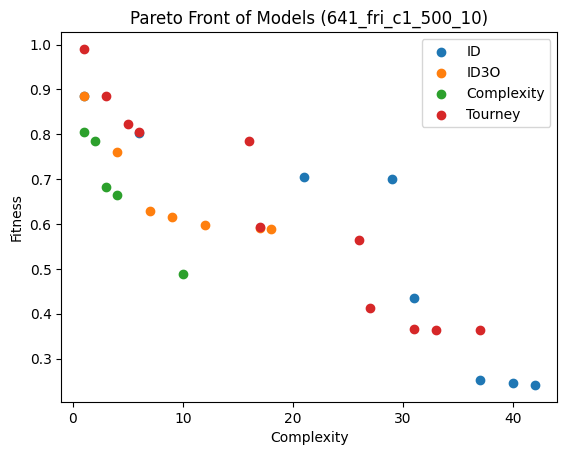

In [15]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (641_fri_c1_500_10)')
plt.legend()

plt.show()

In [16]:
import dill
dill.dump([IDmodels,ID3Omodels,compModels,tourneyModels],open('Models/641_fri_c1_500_10(AvgHess).p','wb'))

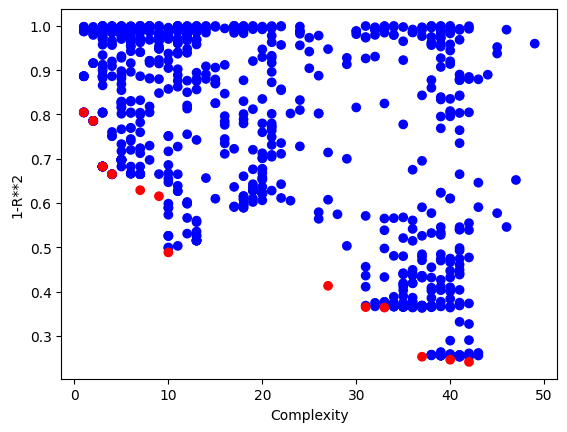

In [17]:
allModels=IDmodels+ID3Omodels+compModels+tourneyModels
plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

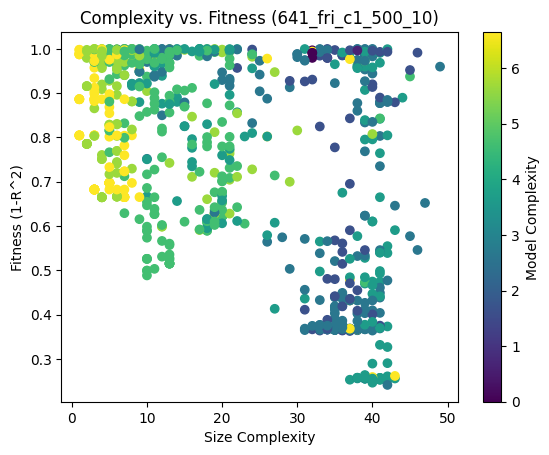

In [18]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (641_fri_c1_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

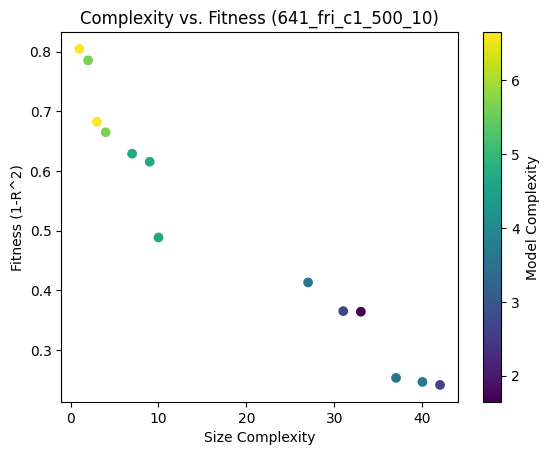

In [19]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (641_fri_c1_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 654_fri_c0_500_10

In [20]:
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/654_fri_c0_500_10/654_fri_c0_500_10.csv')

In [21]:
targetID=8.04
IDrange=1.93    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=100,align=False,elitismRate=10,popSize=300,maxComplexity=300)

ID3O models done [0.37006902974535516, 19, 0.10999999999999921]
ID models done [0.9793496548371585, 0.10999999999999921]
Complexity models done


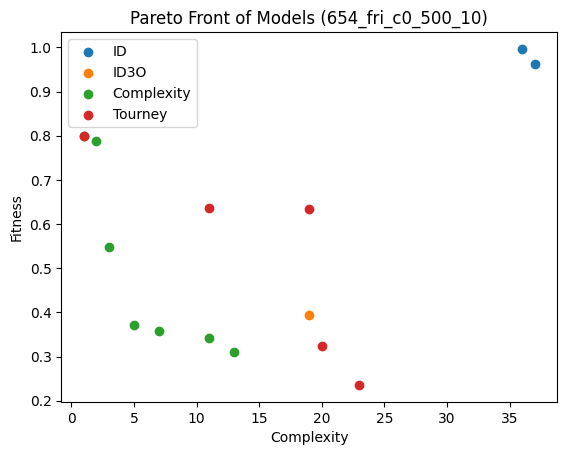

In [22]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models (654_fri_c0_500_10)')
plt.legend()

plt.show()

In [23]:
import dill
dill.dump([IDmodels,ID3Omodels,compModels,tourneyModels],open('Models/654_fri_c0_500_10(AvgHess).p','wb'))

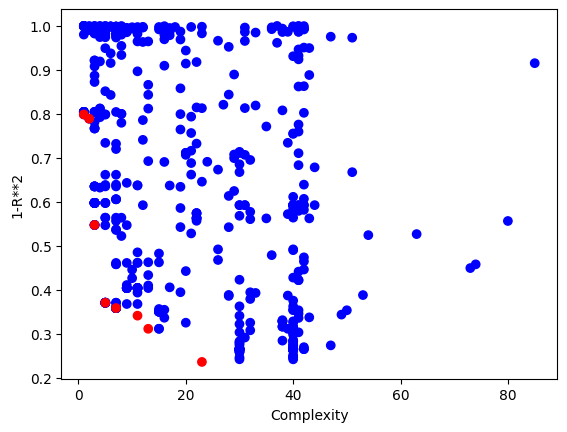

In [24]:
allModels=IDmodels+ID3Omodels+compModels+tourneyModels
plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

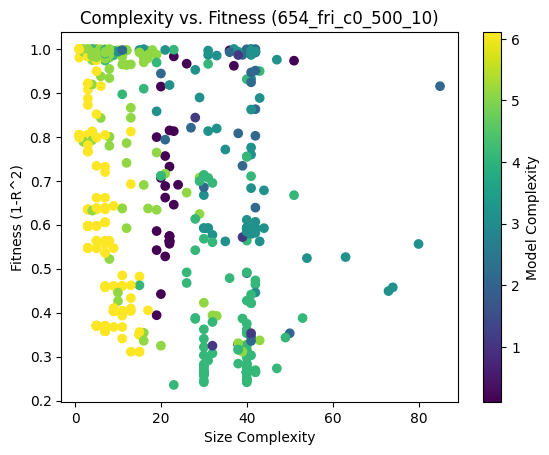

In [25]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (654_fri_c0_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

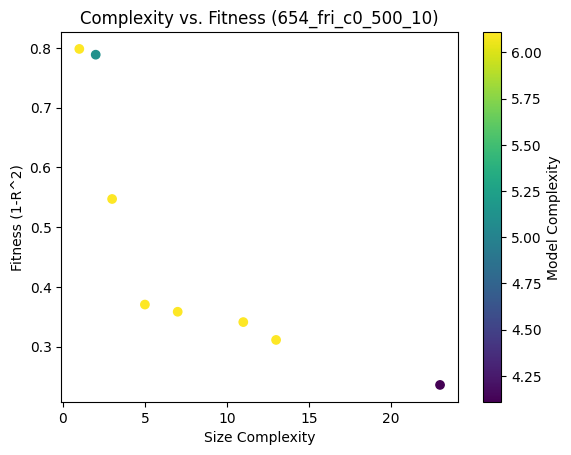

In [26]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness (654_fri_c0_500_10)')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 1027_ESL

In [27]:
name="1027_ESL"
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/'+name+'/'+name+'.csv')

In [28]:
targetID=3.53
IDrange=1.13    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=500,maxComplexity=300)

Complexity models done


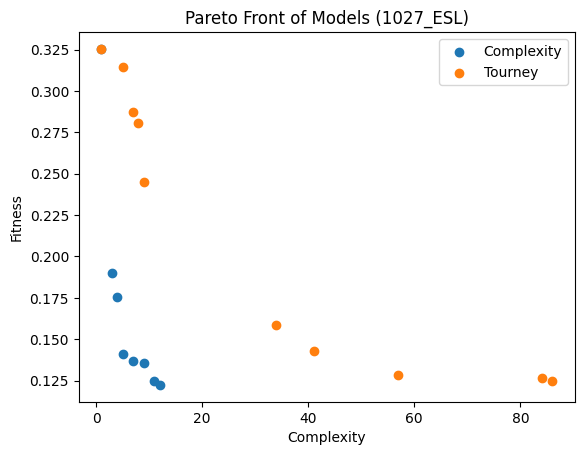

In [29]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([compModels,tourneyModels],open('Models/'+name+'(AvgHess).p','wb'))
allModels=compModels+tourneyModels

ZeroDivisionError: 0.0 cannot be raised to a negative power

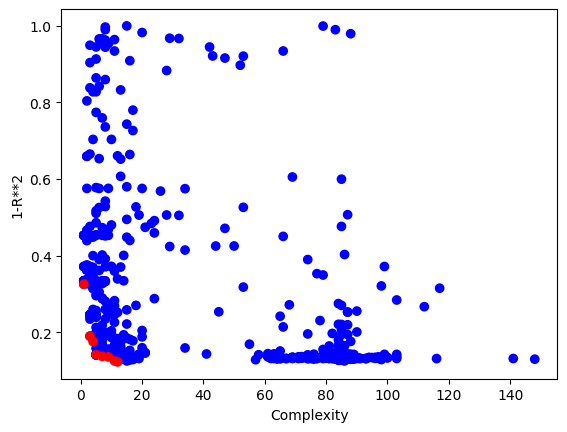

In [30]:

plotModels(allModels)

Text(0, 0.5, 'Fitness (1-R^2)')

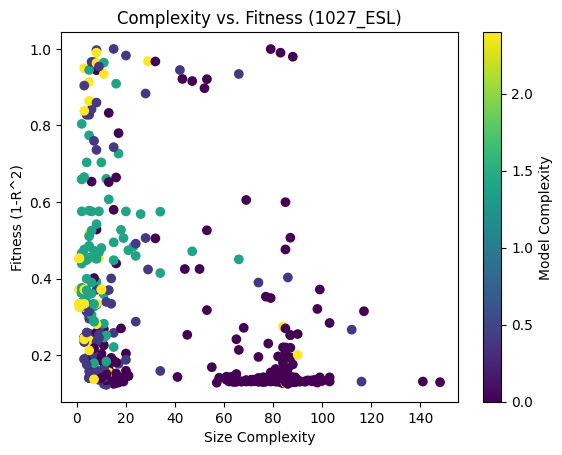

In [31]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

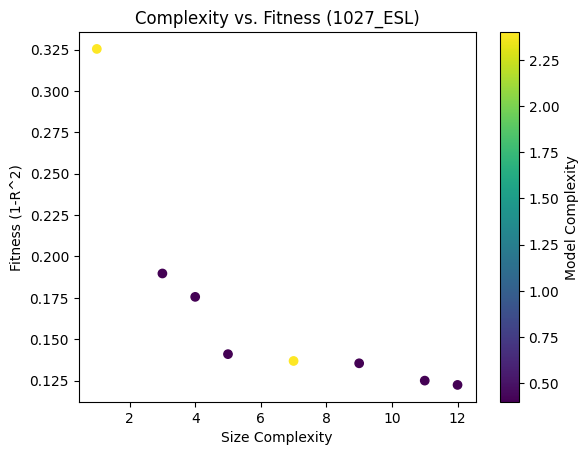

In [32]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 1028_SWD

In [33]:
name="1028_SWD"
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/'+name+'/'+name+'.csv')

In [34]:
targetID=6.79
IDrange=2.63    
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament

compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

Complexity models done


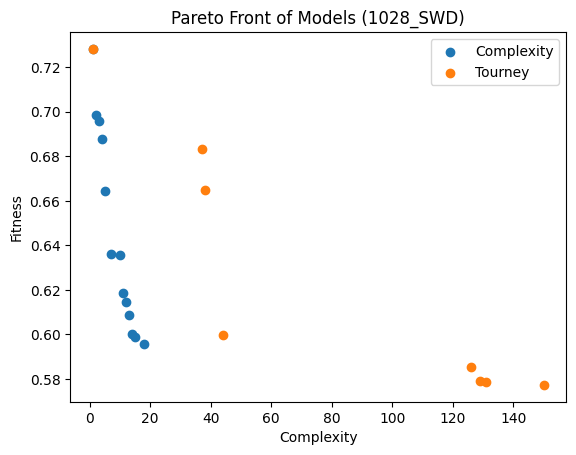

In [35]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]

compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([compModels,tourneyModels],open('Models/'+name+'(AvgHess).p','wb'))
allModels=compModels+tourneyModels

Text(0, 0.5, 'Fitness (1-R^2)')

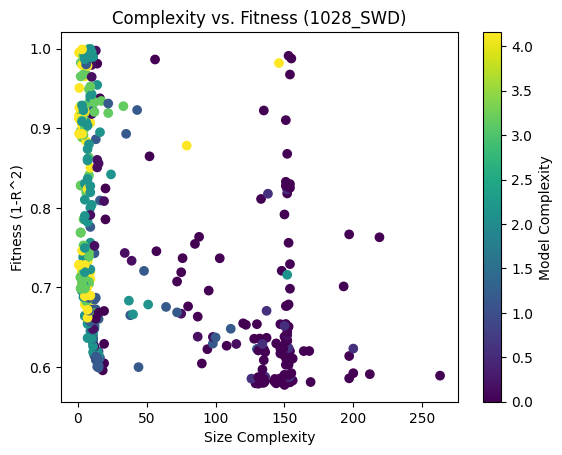

In [36]:
values=[mod[-1]+[func(mod)] for mod in allModels]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

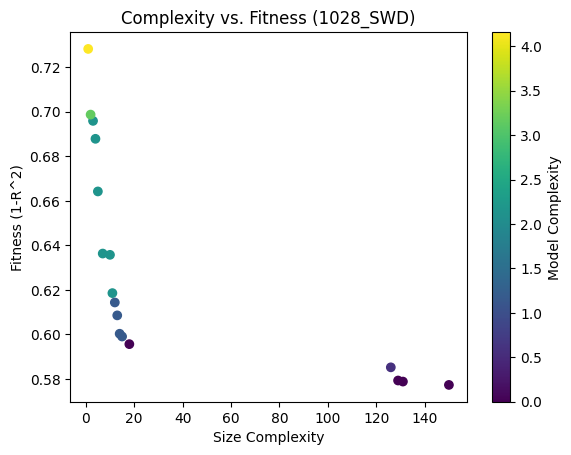

In [37]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 1089_USCrime

In [38]:
name="1089_USCrime"
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/'+name+'/'+name+'.csv')

In [39]:
targetID=3.58
IDrange=2.2    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])
compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

ID3O models done [0.09199155578958373, 23, 0.0]
ID models done [0.049471020457866444, 0.21999999999999975]
Complexity models done


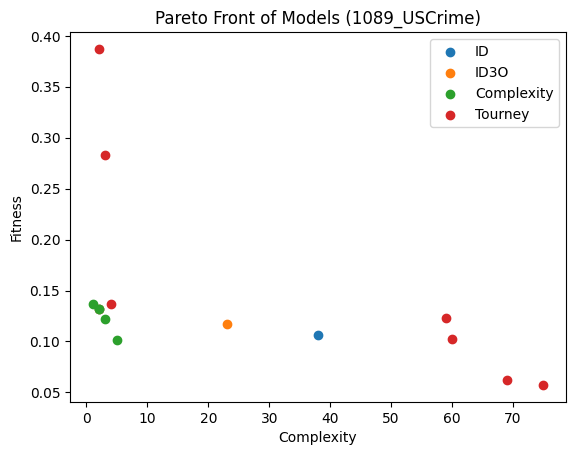

In [40]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]
IDmodels=removeIndeterminateModels(IDmodels)
IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([ID3Omodels,IDmodels,compModels,tourneyModels],open('Models/'+name+'(AvgHess).p','wb'))
allModels=ID3Omodels+IDmodels+compModels+tourneyModels

In [95]:
func(paretoTournament(allModels)[-1])

0.0

Text(0, 0.5, 'Fitness (1-R^2)')

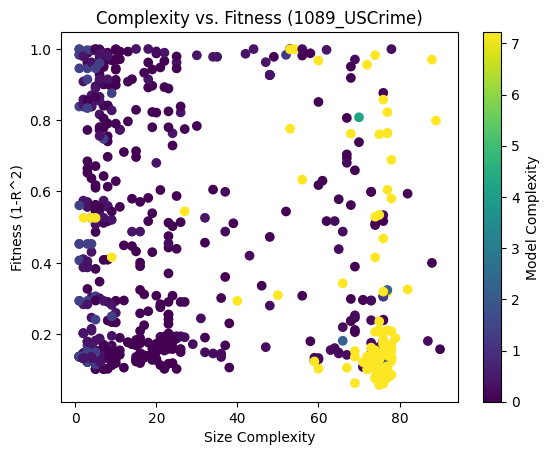

In [41]:
values=[mod[-1]+[func(mod)] for mod in allModels]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

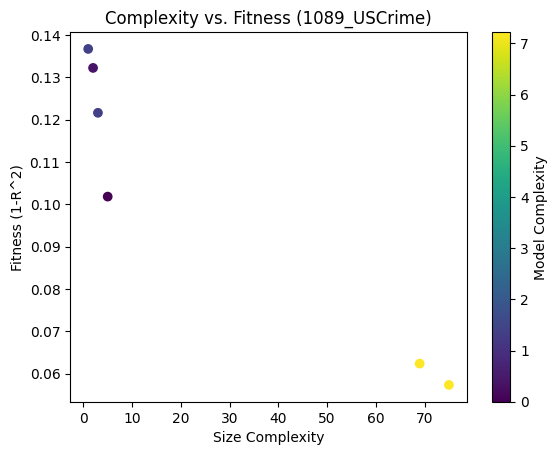

In [42]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

In [131]:
modelComplexities=[stackGPModelComplexity(mod) for mod in ID3Omodels]
modelComplexities

[16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 16,
 13,
 13,
 13,
 13,
 15,
 16,
 18,
 15,
 17,
 18,
 17,
 13,
 21,
 13,
 15,
 15,
 16,
 15,
 13,
 15,
 17,
 13,
 15,
 15,
 16,
 25,
 16,
 17,
 16,
 13,
 17,
 17,
 13,
 13,
 19,
 16,
 16,
 13,
 17,
 13,
 11,
 11,
 16,
 23,
 15,
 13,
 14,
 17,
 17,
 17,
 17,
 17,
 14,
 17,
 13,
 15,
 15,
 14,
 12,
 16,
 17,
 16,
 18,
 14,
 15,
 12,
 14,
 9,
 16,
 10,
 16,
 11,
 14,
 11,
 7,
 10,
 10,
 11,
 13,
 13,
 22,
 18,
 16,
 17,
 17,
 17,
 11,
 12,
 16,
 16,
 19,
 15,
 15,
 6,
 17,
 17,
 18,
 16,
 16,
 8,
 8,
 18,
 14,
 18,
 12,
 10,
 7,
 7,
 17,
 17,
 23,
 16,
 16,
 12,
 13,
 22,
 7,
 3,
 4,
 4,
 5,
 10,
 8,
 15,
 4,
 8,
 11,
 16,
 5,
 14,
 6,
 18,
 17,
 10,
 16,
 6,
 17,
 12,
 11,
 8,
 17,
 16,
 17,
 11,
 14,
 16,
 13,
 14,
 17,
 4,
 14,
 17,
 3,
 11,
 13,
 4,
 4,
 14,
 14,
 13,
 10,
 15,
 15,
 5,
 6,
 15,
 5,
 9]

## 227_cpu_small

In [43]:
name="227_cpu_small"
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/'+name+'/'+name+'.csv')

In [44]:
targetID=2.56
IDrange=0.70    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])
compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

ID3O models done [0.08573236577501486, 18, 0.8600000000000001]
ID models done [0.1380128257978036, 0.74]
Complexity models done


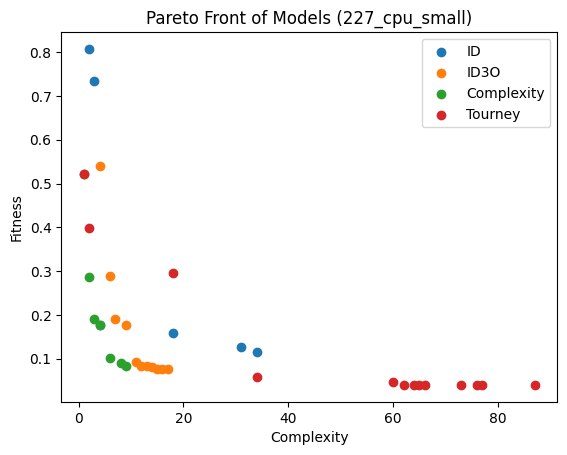

In [45]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]
IDmodels=removeIndeterminateModels(IDmodels)
IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([ID3Omodels,IDmodels,compModels,tourneyModels],open('Models/'+name+'(AvgHess).p','wb'))
allModels=ID3Omodels+IDmodels+compModels+tourneyModels

Text(0, 0.5, 'Fitness (1-R^2)')

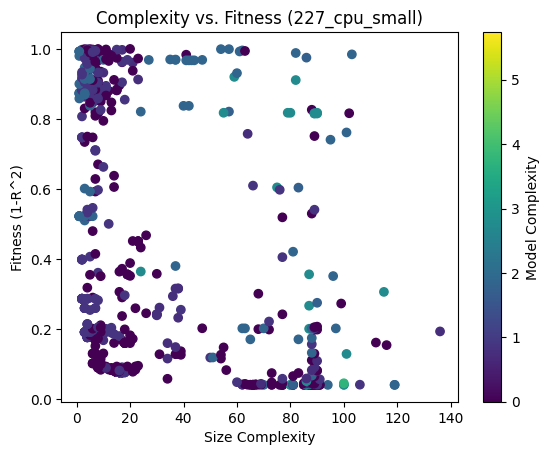

In [46]:
values=[mod[-1]+[func(mod)] for mod in allModels]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

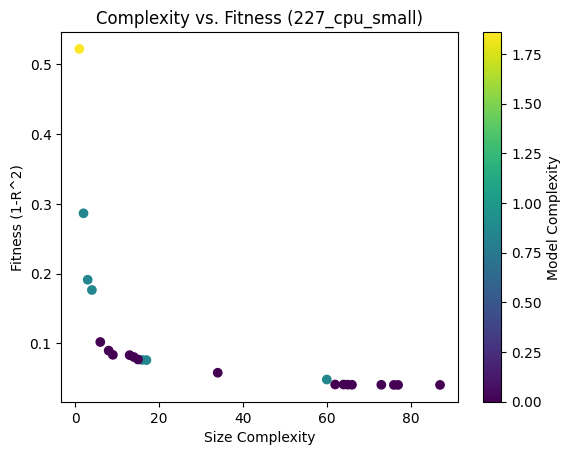

In [47]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

In [48]:
tourneyModelsL=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=1000,align=False,elitismRate=0,popSize=300,maxComplexity=500)

Text(0, 0.5, 'Fitness (1-R^2)')

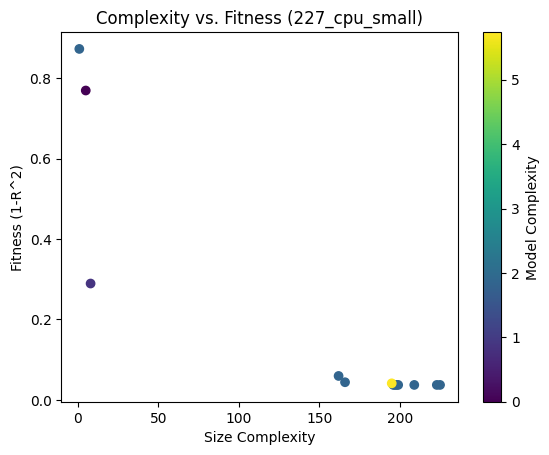

In [49]:
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModelsL]
values=[mod[-1]+[func(mod)] for mod in paretoTournament(tourneyModelsL)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

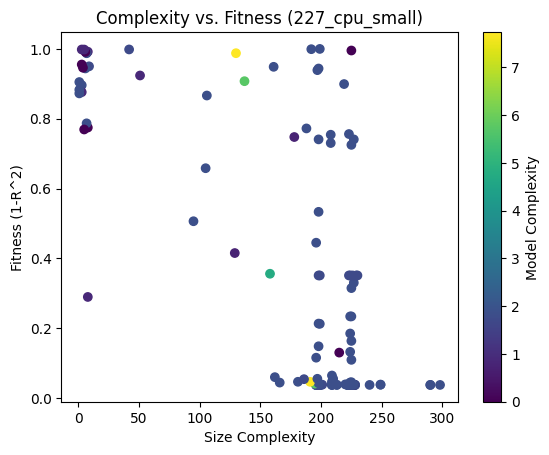

In [50]:
values=[mod[-1]+[func(mod)] for mod in tourneyModelsL]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

## 227_cpu_small (10% Train)

In [5]:
name="227_cpu_small"
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/'+name+'/'+name+'.csv')

In [52]:
targetID=2.56
IDrange=0.70    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)
trainSize=np.floor(len(data)*0.1)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in ID3Omodels if mods[2][2]<1]
if len(temp)>0:
    ID3Omodels=temp
print("ID3O models done", ID3Omodels[0][2])
IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
temp=[mods for mods in IDmodels if mods[2][1]<1]
if len(temp)>0:
    IDmodels=temp
print("ID models done", IDmodels[0][2])
compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

ID3O models done [0.0458196450963162, 22, 0.0]
ID models done [0.0615314219503611, 0.74]
Complexity models done


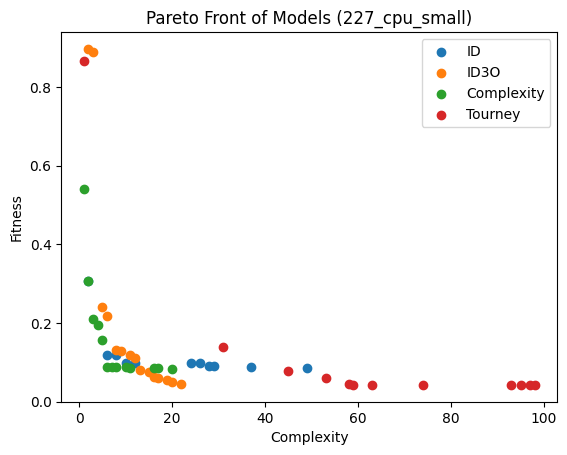

In [53]:
#Pareto front plot of fitnesses vs complexity for each approach
[setModelQuality(mod,testInput,testResponse) for mod in IDmodels]
[setModelQuality(mod,testInput,testResponse) for mod in ID3Omodels]
[setModelQuality(mod,testInput,testResponse) for mod in compModels]
[setModelQuality(mod,testInput,testResponse) for mod in tourneyModels]
IDmodels=removeIndeterminateModels(IDmodels)
IDFront=paretoTournament(IDmodels)
ID3Front=paretoTournament(ID3Omodels)
compFront=paretoTournament(compModels)
tourneyFront=paretoTournament(tourneyModels)

IDFrontComplexities=[stackGPModelComplexity(mod) for mod in IDFront]
IDFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in IDFront]
ID3FrontComplexities=[stackGPModelComplexity(mod) for mod in ID3Front]
ID3FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in ID3Front]
compFrontComplexities=[stackGPModelComplexity(mod) for mod in compFront]
compFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in compFront]
tourneyFrontComplexities=[stackGPModelComplexity(mod) for mod in tourneyFront]
tourneyFrontFitnesses=[fitness(mod,testInput,testResponse) for mod in tourneyFront]

plt.scatter(IDFrontComplexities,IDFrontFitnesses,label='ID')
plt.scatter(ID3FrontComplexities,ID3FrontFitnesses,label='ID3O')
plt.scatter(compFrontComplexities,compFrontFitnesses,label='Complexity')
plt.scatter(tourneyFrontComplexities,tourneyFrontFitnesses,label='Tourney')

plt.xlabel('Complexity')
plt.ylabel('Fitness')
plt.title('Pareto Front of Models ('+name+')')
plt.legend()

plt.show()
import dill
dill.dump([ID3Omodels,IDmodels,compModels,tourneyModels],open('Models/'+name+'(AvgHess)T10.p','wb'))
allModels=ID3Omodels+IDmodels+compModels+tourneyModels

Text(0, 0.5, 'Fitness (1-R^2)')

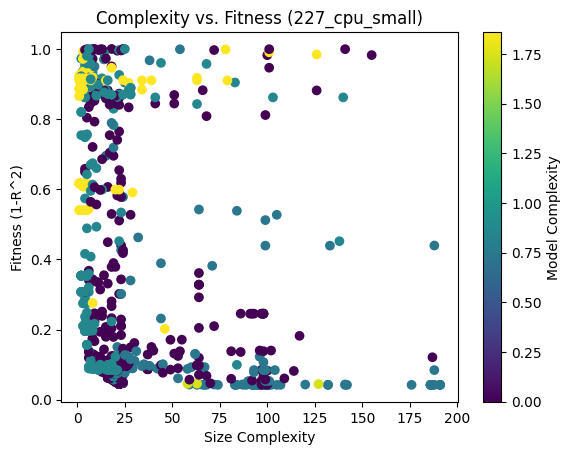

In [54]:
values=[mod[-1]+[func(mod)] for mod in allModels]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

Text(0, 0.5, 'Fitness (1-R^2)')

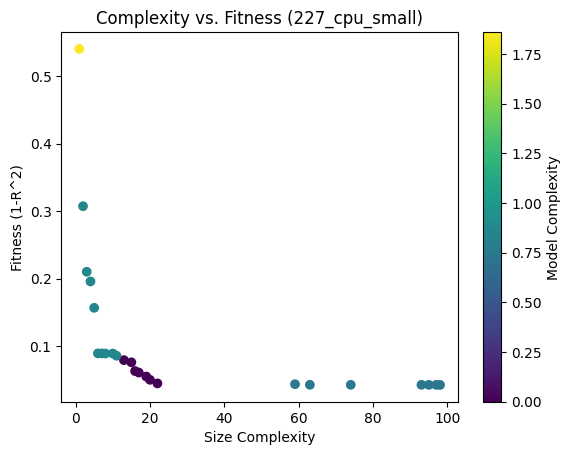

In [55]:
values=[mod[-1]+[func(mod)] for mod in paretoTournament(allModels)]
for i in range(len(values)):
    if values[i][2]>maxDim:
        values[i][2]=maxDim
scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
plt.colorbar(scatter, label='Model Complexity')
plt.title('Complexity vs. Fitness ('+name+')')
plt.xlabel('Size Complexity')
plt.ylabel('Fitness (1-R^2)')

In [6]:
targetID=2.56
IDrange=0.70    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)
trainSize=np.floor(len(data)*0.1)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]


#Get position of max, min, and mean values of response
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)


#Create target basis set function
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])
#Evolve models using three approaches: ID-informed, complexity-informed, and standard tournament
#ID3Omodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness,stackGPModelComplexity],tourneySize=40,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
#temp=[mods for mods in ID3Omodels if mods[2][2]<1]
#if len(temp)>0:
#    ID3Omodels=temp
#print("ID3O models done", ID3Omodels[0][2])
#IDmodels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=20,generations=100,align=False,elitismRate=10,popSize=300,alternateObjectives=[func],alternateObjFrequency=10,maxComplexity=300)
#temp=[mods for mods in IDmodels if mods[2][1]<1]
#if len(temp)>0:
#    IDmodels=temp
#print("ID models done", IDmodels[0][2])
compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
#tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)

Complexity models done


In [28]:
compModels[0][-1]

[0.09258367452693717, 27]

In [30]:
compMods=[mod for mod in compModels if mod[-1][0]<0.2]

In [42]:
sharps=[totalSharpness(mod,trainInput,trainResponse,percentPerturbation=0.2,numPerturbations=20) for mod in compMods]

In [32]:
func=basisFunctionComplexityDiff(targetID,IDrange,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])

ids=[func(mod) for mod in compMods]

In [43]:
#replace nan with 1 in sharps
sharps2=[1 if np.isnan(i) else i for i in sharps]

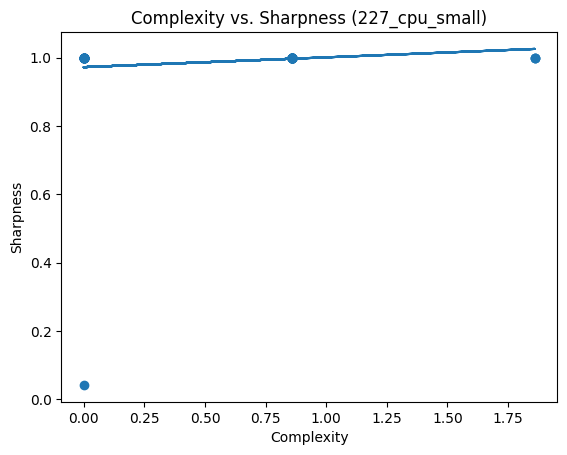

In [44]:
ids=[id if id<maxDim else maxDim for id in ids]
plt.scatter(ids,sharps2)
# Linear fit
m, b = np.polyfit(ids, sharps2, 1)
plt.plot(ids, m*np.array(ids) + b)
plt.xlabel('Complexity')
plt.ylabel('Sharpness')
plt.title('Complexity vs. Sharpness ('+name+')')
plt.show()

In [38]:
sharps2

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.018809274230659728,
 1,
 1,
 1,
 1,
 1]

In [46]:
compModels
comps=[stackGPModelComplexity(mod) for mod in compModels]
ids=[func(mod) for mod in compModels]

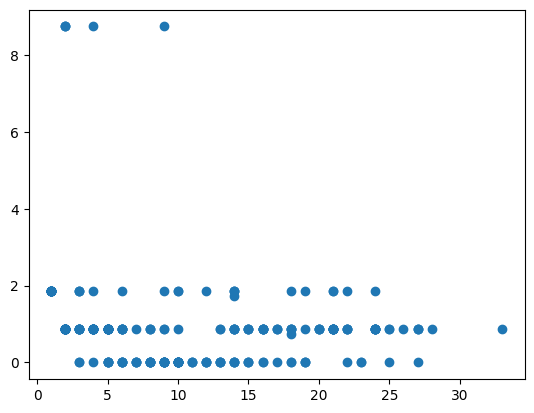

In [48]:
ids=[id if id<maxDim else maxDim for id in ids]
plt.scatter(comps,ids)

## Tuning Study

In [133]:
name="537_houses"
data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/'+name+'/'+name+'.csv')

trainSize=np.floor(len(data)*0.8)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]





compModels=evolve(trainInput,trainResponse,tourneySize=20,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
print("Complexity models done")
tourneyModels=evolve(trainInput,trainResponse,modelEvaluationMetrics=[fitness],tourneySize=5,generations=200,align=False,elitismRate=0,popSize=300,maxComplexity=300)
combModels=compModels+tourneyModels

Complexity models done


In [134]:
#Get position of max, min, and mean values of response
targetID=0
IDrange=0    
totalDim=len(data.columns)-1
maxDim=totalDim-(IDrange+targetID)


maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)

In [171]:
def helperRank2(model,vars,pts):
    try:
        hesses=[ApproxHess(model,vars,pt) for pt in pts]
        totalHess=hesses[0]
        for i in range(1,len(hesses)):
            totalHess+=hesses[i]
        return np.linalg.matrix_rank(totalHess,tol=0.0001*0.0001*10)
    except:
        return 1000

# Creates a lambda function to be used as a complexity metric when given a target dimensionality and deviation
def basisFunctionComplexityDiff2(target, deviation, vars, pts):
    return lambda model,*args: max(abs(helperRank2(model,vars,pts)-target),(deviation))-deviation

In [172]:
func=basisFunctionComplexityDiff2(targetID,IDrange,len(trainInput),[np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1]])

ids=[func(mod) for mod in combModels]

In [173]:
ids[0]

5

In [154]:
helperRank2(combModels[0],8,np.array(trainData)[999][:-1])

0

In [157]:
def ApproxHess2(model,vars,values,diff1=0.001,diff2=0.001):

    hess=[[Approx2Deriv(model,values,diff1,diff2,[i,j]) for i in range(vars)] for j in range(vars)]
    hessN = np.array(hess).astype(float)
    return hessN

In [161]:
model=combModels[0]
diff1=0.001
diff2=0.001
positions=range(9)
values=np.array(trainData)[999][:-1]
term1=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
term1=[term1[i]+diff2 if i == positions[1] else term1[i] for i in range(len(term1))]
term2=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
term2=[term2[i]+diff2 if i == positions[1] else term2[i] for i in range(len(term2))]
term3=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
term3=[term3[i]-diff2 if i == positions[1] else term3[i] for i in range(len(term3))]
term4=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
term4=[term4[i]-diff2 if i == positions[1] else term4[i] for i in range(len(term4))]
((evaluateGPModel(model,term1)-evaluateGPModel(model,term2))/((2*diff1))
        -(evaluateGPModel(model,term3)-evaluateGPModel(model,term4))/((2*diff1)))/(2*diff2)

1.000310945187266e-07

In [168]:
hess=ApproxHess(combModels[0],8,np.array(trainData)[999][:-1])+ApproxHess(combModels[0],8,np.array(trainData)[2][:-1])
np.linalg.matrix_rank(hess,tol=0.0001*0.0001*10)

3

In [175]:
idsVals=[]
for i in [1,2,3,5,10,20]:
    func=basisFunctionComplexityDiff2(targetID,IDrange,len(trainInput),[np.array(trainData)[np.random.randint(0,len(np.array(trainInput)))][:-1] for i in range(i)])
    idsVals.append([func(mod) for mod in combModels])

In [187]:
func=basisFunctionComplexityDiff2(targetID,IDrange,len(trainInput),[np.array(trainData)[np.random.randint(0,len(np.array(trainInput)))][:-1] for i in range(100)])
idsVals.append([func(mod) for mod in combModels])

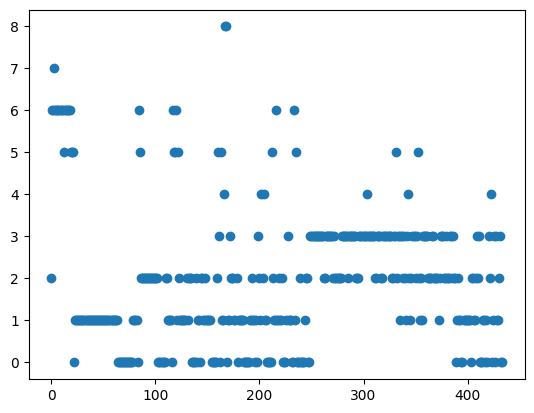

In [176]:
plt.scatter(range(len(np.array(idsVals)[5,:])),np.array(idsVals)[0,:])

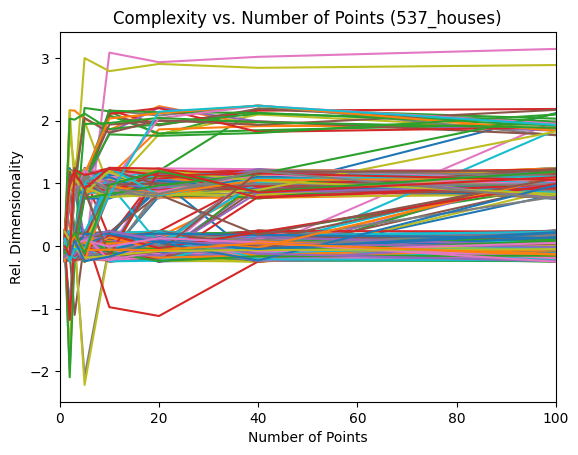

In [241]:
#Box-whisker plot of idsVals vs number of points
[plt.plot([1,2,3,5,10,20,40,100],[i[j]-idsVals[0][j]+(np.random.rand()/2-0.25) for i in idsVals]) for j in range(len(combModels))]
plt.xlabel('Number of Points')
plt.ylabel('Rel. Dimensionality')
plt.title('Complexity vs. Number of Points ('+name+')')
plt.xlim(0,100)
plt.show()

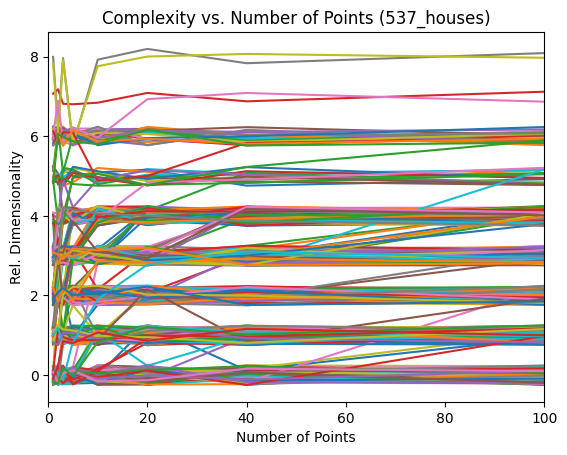

In [285]:
#Box-whisker plot of idsVals vs number of points
[plt.plot([1,2,3,5,10,20,40,100],[i[j]+(np.random.rand()/2-0.25) for i in idsVals]) for j in range(len(combModels))]
plt.xlabel('Number of Points')
plt.ylabel('Rel. Dimensionality')
plt.title('Complexity vs. Number of Points ('+name+')')
plt.xlim(0,100)
plt.show()

237


/var/folders/62/2_vty36j0qzg_znwl_xyjtzw0000gn/T/ipykernel_61856/2956991415.py:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,100)


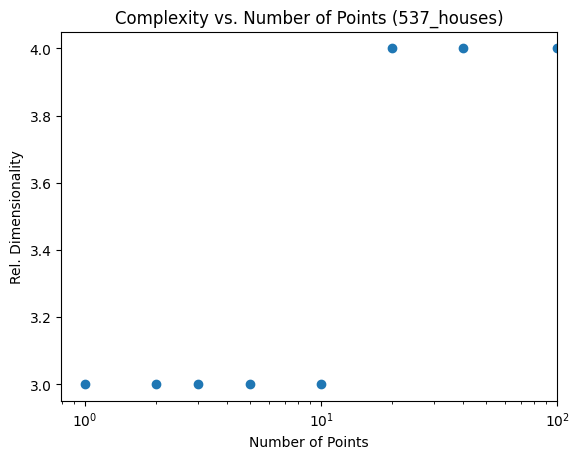

In [284]:
samplePos=np.random.randint(0,len(np.array(idsVals[0])))
print(samplePos)
plt.scatter([1,2,3,5,10,20,40,100],[i[342] for i in idsVals])
plt.xlabel('Number of Points')
plt.ylabel('Rel. Dimensionality')
plt.title('Complexity vs. Number of Points ('+name+')')
plt.xscale('log')
plt.xlim(0,100)
plt.show()

Compare 100 point results against the 3 strategically selected point approach

Text(0.5, 1.0, 'Model Dimensionality with 3 Strategic Pts vs 100 Random Pts (537_houses)')

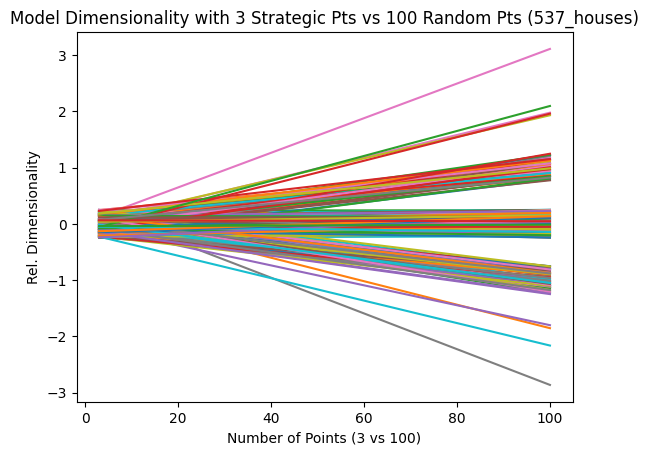

In [240]:
plt.plot([3,100],[np.zeros(len(ids))+np.array([(np.random.rand()/2-0.25) for _ in range(len(ids))]),np.array(idsVals[7])-np.array(ids)+np.array([(np.random.rand()/2-0.25) for _ in range(len(ids))])])
plt.xlabel('Number of Points (3 vs 100)')
plt.ylabel('Rel. Dimensionality')
plt.title('Model Dimensionality with 3 Strategic Pts vs 100 Random Pts ('+name+')')

In [214]:
diff=(np.array(idsVals[7])-np.array(ids))
print(np.sum(abs(diff)<2)/len(ids))

0.9792626728110599


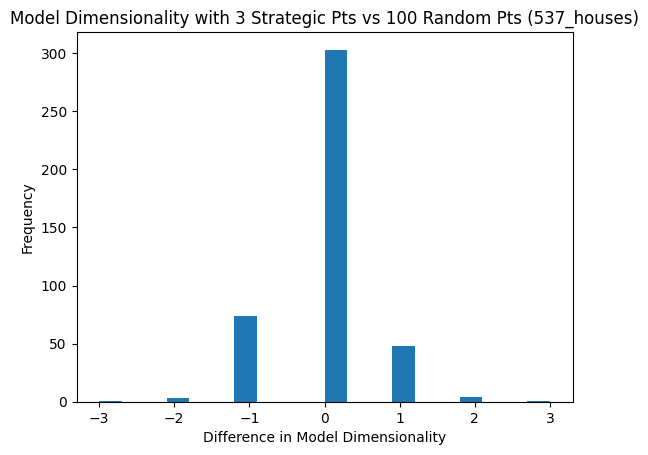

In [213]:
#Historgram of diff
plt.hist(diff,bins=20)
plt.xlabel('Difference in Model Dimensionality')
plt.ylabel('Frequency')
plt.title('Model Dimensionality with 3 Strategic Pts vs 100 Random Pts ('+name+')')
plt.show()

In [178]:
printGPModel(combModels[0])

(x0 - x6 - x7 + x5*(x1 - x7)/(x4*x6))**(-1/8)

## Models for Many Problems

In this section we generate a set of Pareto front models with respect to fitness (R^2) and size complexity for all datasets in the benchmark.

In [1]:
names=["1027_ESL", "1028_SWD", "1029_LEV", "1030_ERA", "1089_USCrime", \
"1096_FacultySalaries", "1191_BNG_pbc", "1193_BNG_lowbwt", \
"1196_BNG_pharynx", "1199_BNG_echoMonths", "1201_BNG_breastTumor", \
"1203_BNG_pwLinear", "1595_poker", "192_vineyard", "195_auto_price", \
"197_cpu_act", "201_pol", "207_autoPrice", "210_cloud", \
"215_2dplanes", "218_house_8L", "225_puma8NH", "227_cpu_small", \
"228_elusage", "229_pwLinear", "230_machine_cpu", \
"294_satellite_image", "344_mv", "4544_GeographicalOriginalofMusic", \
"485_analcatdata_vehicle", "503_wind", "505_tecator", "519_vinnie", \
"522_pm10", "527_analcatdata_election2000", "529_pollen", \
"537_houses", "542_pollution", "547_no2", "556_analcatdata_apnea2", \
"557_analcatdata_apnea1", "560_bodyfat", "561_cpu", "562_cpu_small", \
"564_fried", "573_cpu_act", "574_house_16H", "579_fri_c0_250_5", \
"581_fri_c3_500_25", "582_fri_c1_500_25", "583_fri_c1_1000_50", \
"584_fri_c4_500_25", "586_fri_c3_1000_25", "588_fri_c4_1000_100", \
"589_fri_c2_1000_25", "590_fri_c0_1000_50", "591_fri_c1_100_10", \
"592_fri_c4_1000_25", "593_fri_c1_1000_10", "594_fri_c2_100_5", \
"595_fri_c0_1000_10", "596_fri_c2_250_5", "597_fri_c2_500_5", \
"598_fri_c0_1000_25", "599_fri_c2_1000_5", "601_fri_c1_250_5", \
"602_fri_c3_250_10", "603_fri_c0_250_50", "604_fri_c4_500_10", \
"605_fri_c2_250_25", "606_fri_c2_1000_10", "607_fri_c4_1000_50", \
"608_fri_c3_1000_10", "609_fri_c0_1000_5", "611_fri_c3_100_5", \
"612_fri_c1_1000_5", "613_fri_c3_250_5", "615_fri_c4_250_10", \
"616_fri_c4_500_50", "617_fri_c3_500_5", "618_fri_c3_1000_50", \
"620_fri_c1_1000_25", "621_fri_c0_100_10", "622_fri_c2_1000_50", \
"623_fri_c4_1000_10", "624_fri_c0_100_5", "626_fri_c2_500_50", \
"627_fri_c2_500_10", "628_fri_c3_1000_5", "631_fri_c1_500_5", \
"633_fri_c0_500_25", "634_fri_c2_100_10", "635_fri_c0_250_10", \
"637_fri_c1_500_50", "641_fri_c1_500_10", "643_fri_c2_500_25", \
"644_fri_c4_250_25", "645_fri_c3_500_50", "646_fri_c3_500_10", \
"647_fri_c1_250_10", "648_fri_c1_250_50", "649_fri_c0_500_5", \
"650_fri_c0_500_50", "651_fri_c0_100_25", "653_fri_c0_250_25", \
"654_fri_c0_500_10", "656_fri_c1_100_5", "657_fri_c2_250_10", \
"658_fri_c3_250_25", "659_sleuth_ex1714", "663_rabe_266", \
"665_sleuth_case2002", "666_rmftsa_ladata", \
"678_visualizing_environmental", "687_sleuth_ex1605", \
"690_visualizing_galaxy", "695_chatfield_4", "706_sleuth_case1202", \
"712_chscase_geyser1", "banana", "titanic"]
targets=[3.52576, 6.79268, 3.40836, 3.07211, 3.58032, 1.35562, 4.95926, \
2.9773, 4.74898, 3.72493, 3.68965, 7.63102, 6.84485, 1.65091, \
2.18216, 2.52588, 5.12293, 1.92588, 3.20054, 7.47769, 1.13395, \
6.51742, 2.55937, 1.22647, 7.53071, 8.84275, 8.00285, 3.54541, \
4.56659, 2.19977, 7.1985, 3.63972, 1.73068, 2.13134, 1.45993, \
3.71054, 2.49384, 1.70293, 2.16206, 2.30608, 2.20608, 3.25645, \
9.35359, 2.59046, 8.51492, 2.61351, 2.36664, 4.21961, 15.967, \
16.3237, 30.3178, 15.0877, 15.9703, 49.016, 18.222, 28.721, 6.47696, \
15.779, 7.47982, 3.11206, 8.41629, 3.55208, 3.76544, 17.7072, \
4.18923, 3.52149, 6.14437, 27.2202, 6.04587, 17.2557, 7.21353, \
31.0691, 6.71951, 4.65606, 2.44633, 4.00684, 2.99288, 5.43452, \
30.0513, 3.29246, 29.2407, 16.9752, 7.08747, 28.4856, 6.0066, \
4.10229, 26.9179, 6.93049, 3.54988, 3.92772, 16.9232, 6.27509, \
8.36978, 27.2563, 7.76866, 17.9978, 14.3443, 26.6017, 7.02749, \
7.03379, 25.9356, 4.3716, 27.4737, 13.8747, 16.6945, 8.03984, \
3.44601, 6.71292, 15.0397, 2.40663, 1.88112, 1.94673, 4.50634, \
1.76582, 3.29333, 1.9774, 3.77626, 1.84084, 1.27102, 1.93667, 2.842]
devs=[1.13531, 2.6341, 0.932645, 0.838718, 2.20059, 0.492552, 4.41073, \
1.41916, 2.44981, 1.06922, 1.44257, 1.73977, 2.16147, 0.458462, \
0.927724, 0.665915, 2.36397, 0.264983, 1.18085, 1.90267, 0.221313, \
1.56384, 0.701094, 0.328944, 2.05256, 26.8437, 3.84302, 2.18548, \
2.36163, 1.25018, 2.21097, 1.74463, 1.22547, 0.69502, 0.576616, \
0.411049, 1.0472, 1.43356, 0.682672, 1.1705, 1.2402, 1.29006, \
26.7746, 0.748421, 1.16991, 0.503136, 4.61023, 0.861595, 5.3192, \
6.52667, 13.2517, 5.76909, 6.1082, 32.2605, 5.08328, 15.3788, \
2.25559, 5.08948, 1.60143, 0.745059, 1.41825, 0.526657, 0.808855, \
5.4128, 0.62282, 0.899236, 1.68595, 15.1932, 1.3179, 6.27567, \
2.09559, 13.9574, 1.10397, 0.286622, 0.857199, 0.49504, 1.03589, \
1.67683, 14.5268, 0.881915, 15.0714, 6.31044, 2.7284, 14.258, \
1.46771, 1.17772, 15.7032, 1.79147, 0.93331, 0.406284, 6.83353, \
2.26678, 1.54934, 15.6368, 1.121, 5.5363, 5.97928, 15.0371, 1.21992, \
1.52356, 15.2926, 0.570874, 15.7437, 7.59838, 7.61934, 1.92616, \
0.804168, 1.89137, 6.60114, 0.667794, 0.312803, 0.52888, 1.19187, \
0.463537, 1.04554, 0.611828, 1.79112, 0.52268, 0.335497, 0.336301, \
1.80875]

In [238]:
def generateModels(name,targets,devs):
    data=pd.read_csv('/Users/nathanhaut/Downloads/datasets/'+name+'/'+name+'.csv')

    trainSize=np.floor(len(data)*0.8)
    testSize=len(data)-trainSize

    trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
    testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

    trainData=data.iloc[trainIndices]
    testData=data.iloc[testIndices]

    #Extract input and response data
    trainInput=np.array(trainData.T)[:-1]
    trainResponse=np.array(trainData.T)[-1]
    testInput=np.array(testData.T)[:-1]
    testResponse=np.array(testData.T)[-1]

    tempModels=evolve(trainInput,trainResponse,tourneySize=30,generations=200,align=True,elitismRate=0,popSize=400,maxComplexity=300)

    [setModelQuality(mod,testInput,testResponse) for mod in tempModels]
    tempModels=removeIndeterminateModels(tempModels)
    
    Front=paretoTournament(tempModels)
    
    FrontComplexities=[stackGPModelComplexity(mod) for mod in Front]
    FrontFitnesses=[fitness(mod,testInput,testResponse) for mod in Front]
    
    maxPos=np.argmax(trainResponse)
    minPos=np.argmin(trainResponse)
    diff=np.abs(trainResponse-np.mean(trainResponse))
    meanPos=np.argmin(diff)
    func=basisFunctionComplexityDiff(targets,devs,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])


    values=[mod[-1]+[func(mod)] for mod in Front]
    for i in range(len(values)):
        if values[i][2]>maxDim:
            values[i][2]=maxDim
    scatter=plt.scatter(x=[i[1] for i in values],y=[i[0] for i in values],c=[i[2] for i in values])
    plt.colorbar(scatter, label='Model Complexity')
    plt.title('Complexity vs. Fitness ('+name+')')
    plt.xlabel('Size Complexity')
    plt.ylabel('Fitness (1-R^2)')
    
    #Export plot image
    plt.savefig('Images/'+name+'.png')

    #Clear plot
    plt.clf()



    dill.dump([Front],open('Models/'+name+'Fronts.p','wb'))
    return 0


In [239]:
for i in range(len(names)):
    n=names[i]
    t=targets[i]
    d=devs[i]
    try:
        generateModels(n,t,d)
    except:
        print(n)

 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  5 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  5 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS p

<Figure size 640x480 with 0 Axes>

In [5]:
!pip install matplotplib
!pip install sympy
pip install dill

SyntaxError: invalid syntax (745725517.py, line 3)

In [2]:
import matplotlib.pyplot as plt
from StackGP import *
import pandas as pd

In [3]:
i=0
n=names[i]
t=targets[i]
d=devs[i]
#get dill
print("starting load")
try:
    with open('Models/'+n+'Fronts.p' , 'rb') as f:
        front = dill.load(f)[0]
except:
    print("Error")

starting load


[np.float64(0.13421544679861996), 11]

In [4]:
data=pd.read_csv('/Users/nathanhaut/Library/CloudStorage/OneDrive-MichiganStateUniversity/datasets/'+n+'/'+n+'.csv')

trainSize=np.floor(len(data)*0.8)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

In [5]:
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)

In [ ]:
Approx2Deriv(front[0],np.array(trainData)[0][:-1],0.001,0.001,[0,1])

: 

In [ ]:
positions=[0,1]
values=np.array(trainData)[0][:-1]
diff1=0.001
diff2=0.001
model=front[0]
term1=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
term1=[term1[i]+diff2 if i == positions[1] else term1[i] for i in range(len(term1))]
term2=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
term2=[term2[i]+diff2 if i == positions[1] else term2[i] for i in range(len(term2))]
term3=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
term3=[term3[i]-diff2 if i == positions[1] else term3[i] for i in range(len(term3))]
term4=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
term4=[term4[i]-diff2 if i == positions[1] else term4[i] for i in range(len(term4))]
evaluateGPModel(model,term1)

: 

In [11]:
func=basisFunctionComplexityDiff(t,d,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])


In [ ]:
func(front[0])

: 

In [ ]:
values=[mod[-1]+[func(mod)] for mod in front]

: 

In [ ]:
n=names[i]
t=targets[i]
d=devs[i]
#get dill
print("starting load")
try:
    with open('Models/'+n+'Fronts.p' , 'rb') as f:
        front = dill.load(f)[0]
except:
    continue
print("loaded")
#/Users/nathanhaut/Library/CloudStorage/OneDrive-MichiganStateUniversity/datasets/
#/Users/nathanhaut/Downloads/datasets/
print("Here")
data=pd.read_csv('/Users/nathanhaut/Library/CloudStorage/OneDrive-MichiganStateUniversity/datasets/'+n+'/'+n+'.csv')

trainSize=np.floor(len(data)*0.8)
testSize=len(data)-trainSize

trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

trainData=data.iloc[trainIndices]
testData=data.iloc[testIndices]

#Extract input and response data
trainInput=np.array(trainData.T)[:-1]
trainResponse=np.array(trainData.T)[-1]
testInput=np.array(testData.T)[:-1]
testResponse=np.array(testData.T)[-1]
maxPos=np.argmax(trainResponse)
minPos=np.argmin(trainResponse)
diff=np.abs(trainResponse-np.mean(trainResponse))
meanPos=np.argmin(diff)

func=basisFunctionComplexityDiff(t,d,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])


values=[mod[-1]+[func(mod)] for mod in front]
idealRange=[]
closeRange=[]
farRange=[]
for j in range(len(values)):
    if values[j][2]==0:
        idealRange.append(values[j])
    elif values[j][2]<=1 and values[j][2]>0:
        closeRange.append(values[j])
    else:
        farRange.append(values[j])

#Box-whisker plot of idealRange vs closeRange vs farRange
if len(idealRange)>0:
    count+=1
    labelList=[]
    resultsList=[]
    mins=[]
    if len(idealRange)>0:
        mins.append(min(np.array(idealRange)[:,0]))
    if len(closeRange)>0:
        mins.append(min(np.array(closeRange)[:,0]))
    if len(farRange)>0:
        mins.append(min(np.array(farRange)[:,0]))
    minScalar=min(mins)
    if len(idealRange)>0:
        labelList.append('Ideal')
        resultsList.append(np.array(idealRange)[:,0])
        for j in np.array(idealRange)[:,0]:
            idealList.append(j-minScalar)
    if len(closeRange)>0:
        labelList.append('Close')
        resultsList.append(np.array(closeRange)[:,0])
        for j in np.array(closeRange)[:,0]:
            closeList.append(j-minScalar)
    if len(farRange)>0:
        labelList.append('Far')
        resultsList.append(np.array(farRange)[:,0])
        for j in np.array(farRange)[:,0]:
            farList.append(j-minScalar)

here


In [4]:
import matplotlib.pyplot as plt
from StackGP import *
import pandas as pd
idealList=[]
closeList=[]
farList=[]
count=0
print("here")
for i in range(len(names)):
    n=names[i]
    t=targets[i]
    d=devs[i]
    #get dill
    print("starting load")
    try:
        with open('Models/'+n+'Fronts.p' , 'rb') as f:
            front = dill.load(f)[0]
    except:
        continue
    print("loaded")
    #/Users/nathanhaut/Library/CloudStorage/OneDrive-MichiganStateUniversity/datasets/
    #/Users/nathanhaut/Downloads/datasets/
    print("Here")
    data=pd.read_csv('/Users/nathanhaut/Library/CloudStorage/OneDrive-MichiganStateUniversity/datasets/'+n+'/'+n+'.csv')

    trainSize=np.floor(len(data)*0.8)
    testSize=len(data)-trainSize

    trainIndices=np.random.choice(len(data),int(trainSize),replace=False)
    testIndices=np.setdiff1d(np.arange(len(data)),trainIndices)

    trainData=data.iloc[trainIndices]
    testData=data.iloc[testIndices]

    #Extract input and response data
    trainInput=np.array(trainData.T)[:-1]
    trainResponse=np.array(trainData.T)[-1]
    testInput=np.array(testData.T)[:-1]
    testResponse=np.array(testData.T)[-1]
    maxPos=np.argmax(trainResponse)
    minPos=np.argmin(trainResponse)
    diff=np.abs(trainResponse-np.mean(trainResponse))
    meanPos=np.argmin(diff)

    func=basisFunctionComplexityDiff(t,d,len(trainInput),np.array(trainData)[minPos][:-1],np.array(trainData)[maxPos][:-1],np.array(trainData)[meanPos][:-1])


    values=[mod[-1]+[func(mod)] for mod in front]
    idealRange=[]
    closeRange=[]
    farRange=[]
    for j in range(len(values)):
        if values[j][2]==0:
            idealRange.append(values[j])
        elif values[j][2]<=1 and values[j][2]>0:
            closeRange.append(values[j])
        else:
            farRange.append(values[j])

    #Box-whisker plot of idealRange vs closeRange vs farRange
    if len(idealRange)>0:
        count+=1
        labelList=[]
        resultsList=[]
        mins=[]
        if len(idealRange)>0:
            mins.append(min(np.array(idealRange)[:,0]))
        if len(closeRange)>0:
            mins.append(min(np.array(closeRange)[:,0]))
        if len(farRange)>0:
            mins.append(min(np.array(farRange)[:,0]))
        minScalar=min(mins)
        if len(idealRange)>0:
            labelList.append('Ideal')
            resultsList.append(np.array(idealRange)[:,0])
            for j in np.array(idealRange)[:,0]:
                idealList.append(j-minScalar)
        if len(closeRange)>0:
            labelList.append('Close')
            resultsList.append(np.array(closeRange)[:,0])
            for j in np.array(closeRange)[:,0]:
                closeList.append(j-minScalar)
        if len(farRange)>0:
            labelList.append('Far')
            resultsList.append(np.array(farRange)[:,0])
            for j in np.array(farRange)[:,0]:
                farList.append(j-minScalar)

    #plt.boxplot(resultsList,labels=labelList)
    #plt.xlabel('Complexity')
    #plt.ylabel('Fitness')
    #plt.title('Complexity vs. Fitness ('+n+')')
    #plt.legend()
    #plt.show()
plt.boxplot([idealList,closeList,farList],labels=['Ideal','Close','Far'])
plt.xlabel('Complexity')
plt.ylabel('Relative Fitness')
plt.title('Fitness vs. Complexity')
plt.legend()

# Export idealList closeList farList to csv
import csv
with open('FitnessVsComplexity.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Ideal','Close','Far'])
    for i in range(len(idealList)):
        writer.writerow([idealList[i],closeList[i],farList[i]])


            

: 

/var/folders/62/2_vty36j0qzg_znwl_xyjtzw0000gn/T/ipykernel_936/3650798791.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp=plt.boxplot([idealList,closeList,farList],labels=['Ideal','Close','Far'],conf_intervals=[[0.25,0.75],[0.25,0.75],[0.25,0.75]])
/var/folders/62/2_vty36j0qzg_znwl_xyjtzw0000gn/T/ipykernel_936/3650798791.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


AttributeError: 'dict' object has no attribute 'errorbar'

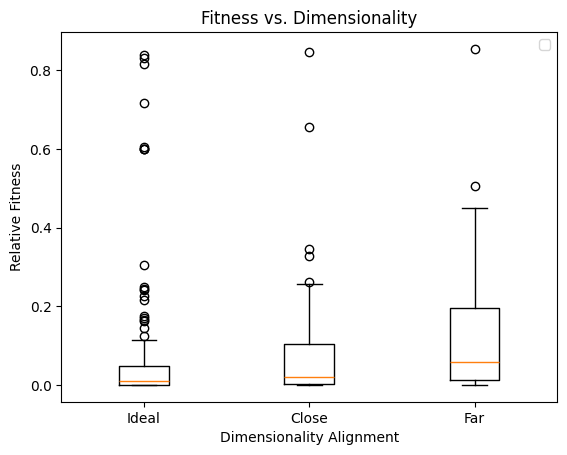

In [15]:
bp=plt.boxplot([idealList,closeList,farList],labels=['Ideal','Close','Far'],conf_intervals=[[0.25,0.75],[0.25,0.75],[0.25,0.75]])
plt.xlabel('Dimensionality Alignment')
plt.ylabel('Relative Fitness')
plt.title('Fitness vs. Dimensionality')
plt.legend()

se = [np.std(group) / np.sqrt(len(group)) for group in [idealList,closeList,farList]]

# Add error bars
for i, median in enumerate(bp['medians']):
    x = median.get_xdata()[0]
    y = median.get_ydata()[0]
    bp.errorbar(x, y, yerr=se[i], fmt='o', color='black', capsize=5)

/var/folders/62/2_vty36j0qzg_znwl_xyjtzw0000gn/T/ipykernel_936/1935680482.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True,labels=['Ideal','Close','Far'])


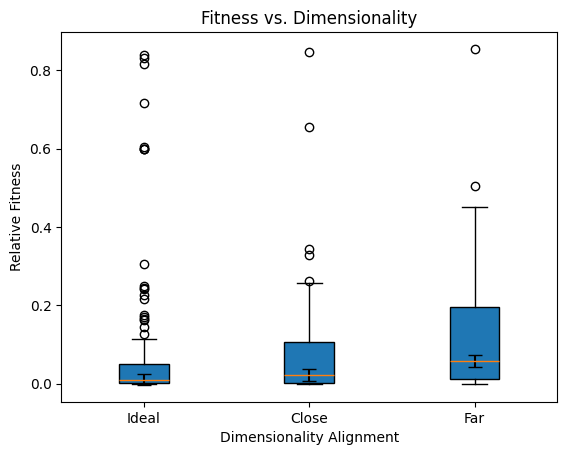

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = [idealList,closeList,farList]

# Create the boxplot
fig, ax = plt.subplots()
bp = ax.boxplot(data, patch_artist=True,labels=['Ideal','Close','Far'])

# Calculate standard error for each group
se = [np.std(group) / np.sqrt(len(group)) for group in data]

# Add error bars
for i, median in enumerate(bp['medians']):
    x = median.get_xdata()[0]+0.15
    y = median.get_ydata()[0]
    ax.errorbar(x, y, yerr=se[i], fmt='', color='black', capsize=5)
plt.xlabel('Dimensionality Alignment')
plt.ylabel('Relative Fitness')
plt.title('Fitness vs. Dimensionality')
plt.show()


In [37]:
[np.median(x) for x in [idealList,closeList,farList]]

[0.010141501135385256, 0.02128878022160352, 0.05725400913966716]

In [26]:
np.std(idealList)/np.sqrt(len(idealList))

0.013395093881722045

In [28]:
np.std(closeList)/np.sqrt(len(closeList))

0.015239806559552503

In [29]:
np.std(farList)/np.sqrt(len(farList))

0.015527849658398556

In [351]:
print(len(idealList))
print(len(closeList))
print(len(farList))

125
58
52
